<a href="https://colab.research.google.com/github/meti-94/CodingQuestions/blob/main/Descriptive%20Analysis/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle -q
!pip install transformers -q
!pip install sentence-transformers -q

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!mkdir ~/.kaggle
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c fake-news

 77% 36.0M/46.5M [00:00<00:00, 207MB/s] 
100% 46.5M/46.5M [00:00<00:00, 214MB/s]


In [5]:
!unzip -qq /content/fake-news.zip

In [2]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import InputExample
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sentence_transformers import losses
from sklearn.manifold import TSNE
from collections import Counter

In [14]:
df = pd.read_csv('/content/train.csv')
df.dropna(inplace=True)
df = df[:1000] ##############
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 1147
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1000 non-null   int64 
 1   title   1000 non-null   object
 2   author  1000 non-null   object
 3   text    1000 non-null   object
 4   label   1000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 46.9+ KB


Data Cleaning

In [16]:
import re
def clean_data(x):
    text = x
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text) # remove puncs
    text = re.sub('\n', '', text)
    return text
cleaned = df.copy()
cleaned['title'] = cleaned.title.astype(str).apply(lambda x : clean_data(x))
cleaned['text'] = cleaned.text.astype(str).apply(lambda x : clean_data(x))
cleaned.head()

,id,title,author,text,label
0,0,house dem aide we didnt even see comeys letter...,Darrell Lucus,house dem aide we didnt even see comeys letter...,1
1,1,flynn hillary clinton big woman on campus bre...,Daniel J. Flynn,ever get the feeling your life circles the rou...,0
2,2,why the truth might get you fired,Consortiumnews.com,why the truth might get you fired october th...,1
3,3,civilians killed in single us airstrike have ...,Jessica Purkiss,videos civilians killed in single us airstrik...,1
4,4,iranian woman jailed for fictional unpublished...,Howard Portnoy,print an iranian woman has been sentenced to s...,1


In [17]:
nltk.download('stopwords')
nltk.download('punkt')
eng_stopwords = nltk.corpus.stopwords.words("english")
def remove_eng_stopwords(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [word for word in token_text if word not in eng_stopwords]
    join_text = ' '.join(remove_stop)
    return join_text

sw_free = df.copy()
sw_free['title'] = sw_free.title.astype(str).apply(lambda x : remove_eng_stopwords(x))
sw_free['text'] = sw_free.text.astype(str).apply(lambda x : remove_eng_stopwords(x))
sw_free.head()  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,title,author,text,label
0,0,House Dem Aide : We Didn ’ Even See Comey ’ Le...,Darrell Lucus,House Dem Aide : We Didn ’ Even See Comey ’ Le...,1
1,1,"FLYNN : Hillary Clinton , Big Woman Campus - B...",Daniel J. Flynn,Ever get feeling life circles roundabout rathe...,0
2,2,Why Truth Might Get You Fired,Consortiumnews.com,"Why Truth Might Get You Fired October 29 , 201...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed fictional unpublished sto...,Howard Portnoy,Print An Iranian woman sentenced six years pri...,1


In [18]:
lemm = WordNetLemmatizer()
def word_lemmatizer(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [lemm.lemmatize(w) for w in token_text]
    join_text = ' '.join(remove_stop)
    return join_text
lemmatized = sw_free.copy()
lemmatized['title'] = lemmatized.title.astype(str).apply(lambda x : remove_eng_stopwords(x))
lemmatized['text'] = lemmatized.text.astype(str).apply(lambda x : remove_eng_stopwords(x))
lemmatized.head()

,id,title,author,text,label
0,0,House Dem Aide : We Didn ’ Even See Comey ’ Le...,Darrell Lucus,House Dem Aide : We Didn ’ Even See Comey ’ Le...,1
1,1,"FLYNN : Hillary Clinton , Big Woman Campus - B...",Daniel J. Flynn,Ever get feeling life circles roundabout rathe...,0
2,2,Why Truth Might Get You Fired,Consortiumnews.com,"Why Truth Might Get You Fired October 29 , 201...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed fictional unpublished sto...,Howard Portnoy,Print An Iranian woman sentenced six years pri...,1


In [19]:
cleaned_sw_free = cleaned.copy()
cleaned_sw_free['title'] = cleaned_sw_free.title.astype(str).apply(lambda x : remove_eng_stopwords(x))
cleaned_sw_free['text'] = cleaned_sw_free.text.astype(str).apply(lambda x : remove_eng_stopwords(x))

list_words = cleaned_sw_free['text'].str.split()
list_words_merge = list(chain(*list_words))

d = Counter(list_words_merge)
df = pd.DataFrame(data=d, index=['count'])
top_common_words = df.T.sort_values(by=['count'], ascending=False).reset_index().head(50)
top_common_words.head()

,index,count
0,said,4298
1,mr,3903
2,trump,2512
3,would,2075
4,one,2000


Plotting Some of the Characteristics of Data


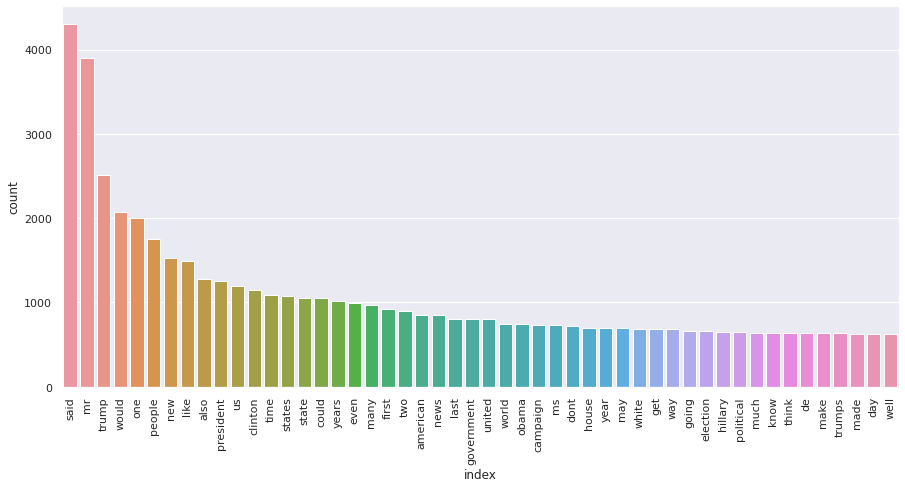

In [20]:
plt.figure(figsize=(15,7))
sns.set(style="darkgrid")
sns.barplot(x="index", y='count', data=top_common_words)
_ = plt.xticks(rotation=90)

In [21]:
nltk.download('wordnet')
nltk.download('omw-1.4')
cleaned_lemmatized_sw_free = cleaned_sw_free.copy()
cleaned_lemmatized_sw_free['title'] = cleaned_lemmatized_sw_free.title.astype(str).apply(lambda x : word_lemmatizer(x))
cleaned_lemmatized_sw_free['text'] = cleaned_lemmatized_sw_free.text.astype(str).apply(lambda x : word_lemmatizer(x))

string = ' '.join(cleaned_lemmatized_sw_free['text'])
str_val = string.split(" ")
data_unigram=(pd.Series(nltk.ngrams(str_val, 1)).value_counts())[:30]
data_unigram_df=pd.DataFrame(data_unigram)
data_unigram_df = data_unigram_df.reset_index()
data_unigram_df = data_unigram_df.rename(columns={"index": "key", 0: "value"})
data_unigram_df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,key,value
0,"(said,)",4298
1,"(mr,)",4159
2,"(trump,)",3147
3,"(state,)",2130
4,"(one,)",2099


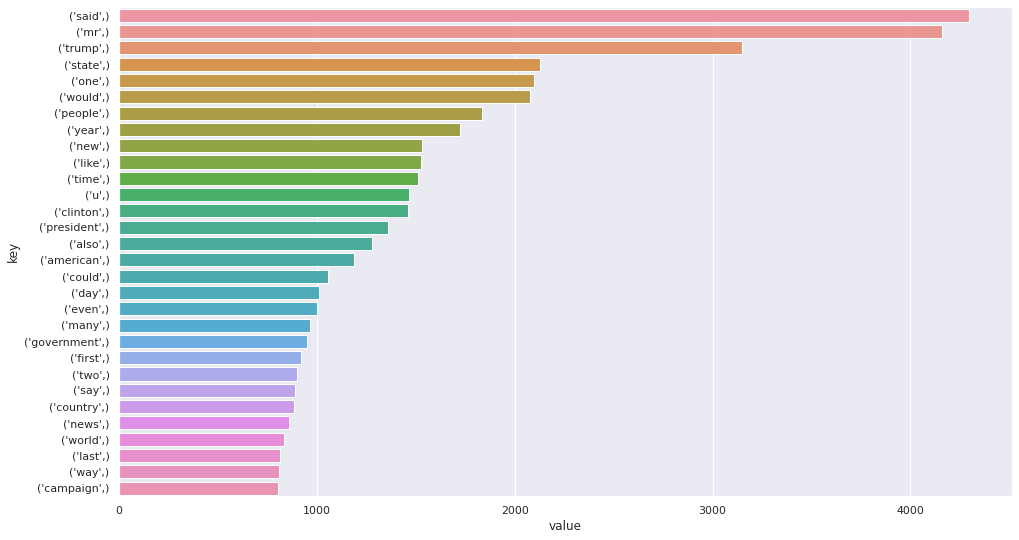

In [22]:
plt.figure(figsize = (16,9))
_ = sns.barplot(x='value',y='key', data=data_unigram_df)

In [23]:
data_bigram=(pd.Series(nltk.ngrams(str_val, 2)).value_counts())[:30]
data_bigram_df=pd.DataFrame(data_bigram)
data_bigram_df = data_bigram_df.reset_index()
data_bigram_df = data_bigram_df.rename(columns={"index": "key", 0: "value"})
data_bigram_df.head()

,key,value
0,"(mr, trump)",1036
1,"(united, state)",638
2,"(hillary, clinton)",449
3,"(donald, trump)",401
4,"(new, york)",393


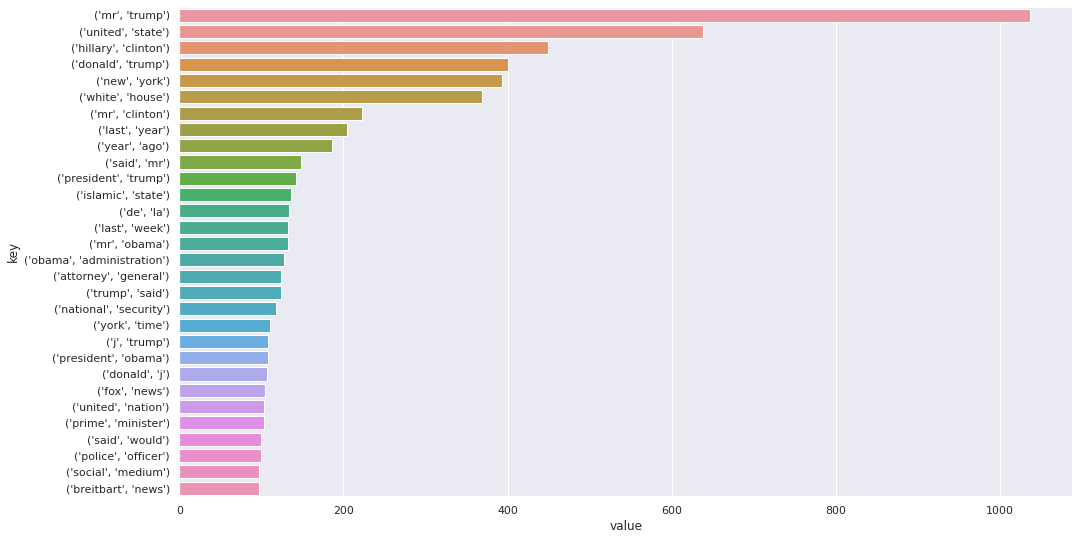

In [24]:
plt.figure(figsize = (16,9))
sns.barplot(x='value',y='key', data=data_bigram_df)

In [25]:
data_trigram=(pd.Series(nltk.ngrams(str_val, 3)).value_counts())[:30]
data_trigram_df=pd.DataFrame(data_trigram)
data_trigram_df = data_trigram_df.reset_index()
data_trigram_df = data_trigram_df.rename(columns={"index": "key", 0: "value"})
data_trigram_df.head()

,key,value
0,"(new, york, time)",109
1,"(donald, j, trump)",107
2,"(mr, trump, said)",69
3,"(president, donald, trump)",62
4,"(george, w, bush)",56


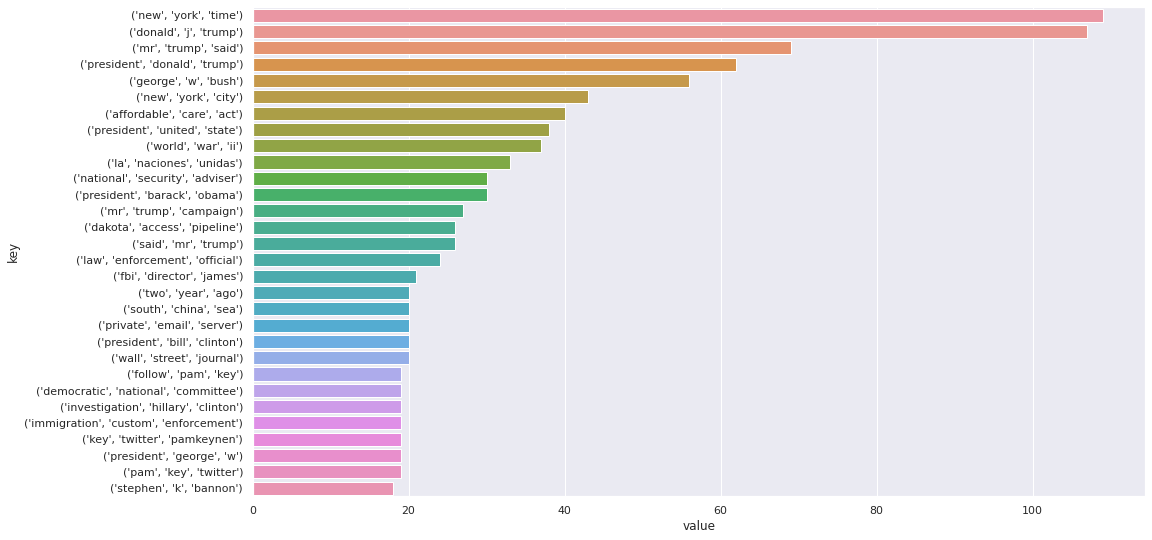

In [26]:
plt.figure(figsize = (16,9))
_ = sns.barplot(x='value',y='key', data=data_trigram_df)

In [27]:
import string

In [29]:
df = pd.read_csv('/content/train.csv').dropna()
df['title_len'] = df['title'].astype(str).apply(lambda txt:len(list(txt)))
df['text_len'] = df['text'].astype(str).apply(lambda txt:len(list(txt)))
df['title_stopwords'] = df['title'].astype(str).apply(lambda txt:len([item for item in txt.split() if item in eng_stopwords]))
df['text_stopwords'] = df['text'].astype(str).apply(lambda txt:len([item for item in txt.split() if item in eng_stopwords]))
df['title_puncs'] = df['title'].astype(str).apply(lambda txt:len([item for item in txt.split() if item in string.punctuation]))
df['text_puncs'] = df['text'].astype(str).apply(lambda txt:len([item for item in txt.split() if item in string.punctuation]))
df['title_unique'] = df['title'].astype(str).apply(lambda txt:len(set(txt.split())))
df['text_unique'] = df['text'].astype(str).apply(lambda txt:len(set(txt.split())))
df

,id,title,author,text,label,title_len,text_len,title_stopwords,text_stopwords,title_puncs,text_puncs,title_unique,text_unique
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,81,4930,0,322,0,4,14,432
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,55,4160,1,286,1,0,9,417
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,33,7692,1,493,0,2,7,659
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,63,3237,0,212,0,0,10,277
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,93,938,4,58,0,1,12,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,55,1814,1,105,0,0,9,200
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,65,6059,1,453,1,8,11,455
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,80,4799,2,304,1,0,15,438
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,50,1773,0,84,0,0,8,177


In [33]:
grouped = df.groupby('author')
authers_reliabilty = {}
for name, group in grouped:
  if len(group)>5:
    authers_reliabilty[name] = float(group['label'].astype(int).sum()/len(group))
print(Counter(list(authers_reliabilty.values())))

Counter({0.0: 357, 1.0: 263, 0.23809523809523808: 1, 0.00411522633744856: 1, 0.3333333333333333: 1})


In [34]:
def plot_histogram(textno, textye, label):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno, ax=axes[0], color='#e74c3c')
    sns.distplot(textye, ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel(label)
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Reliable')
    axes[1].set_xlabel(label)
    axes[1].set_title('Unreliable')
    
    fig.suptitle('Fake News', fontsize=24, va='baseline')
    
    fig.tight_layout()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


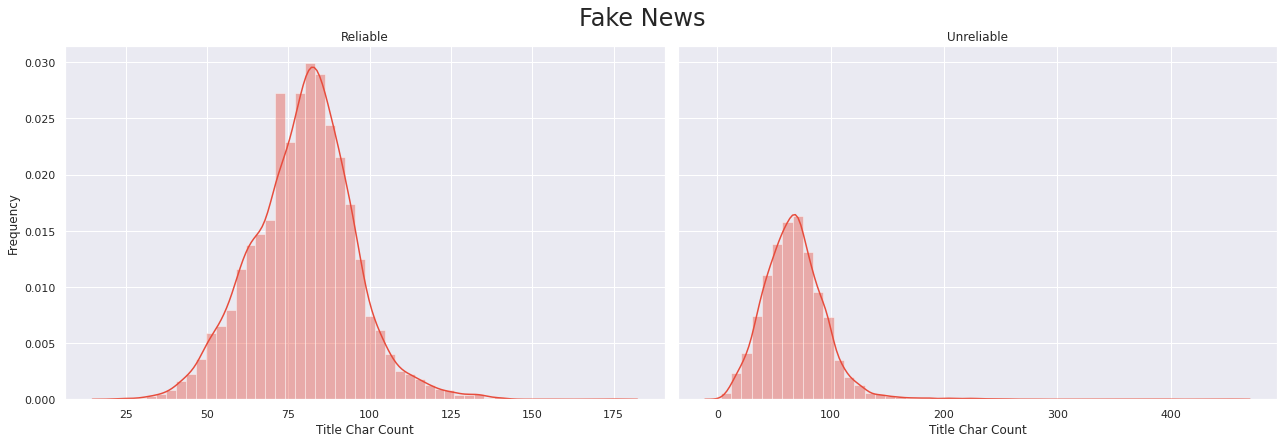

In [35]:
plot_histogram(df[df['label'] == 0]['title_len'], df[df['label'] == 1]['title_len'], 'Title Char Count')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


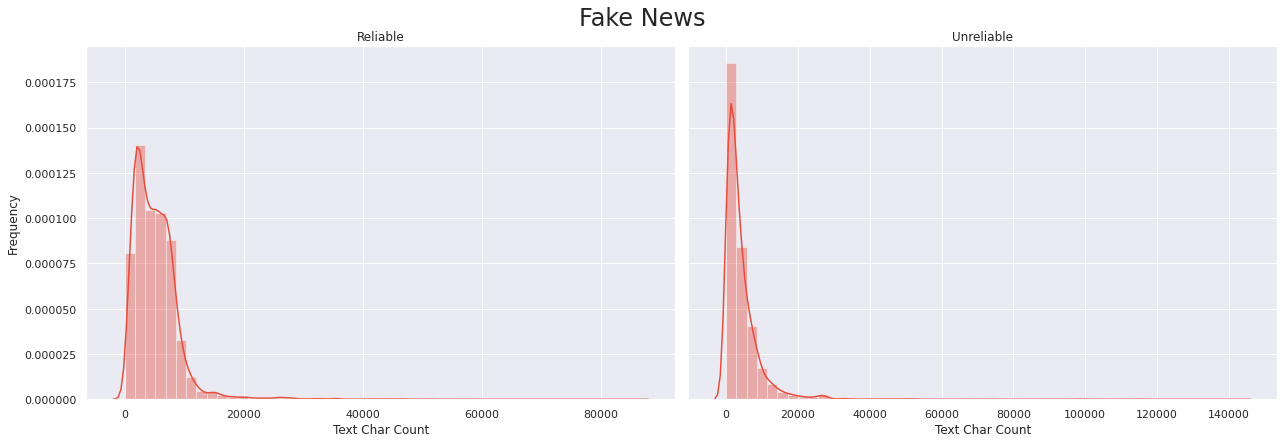

In [36]:
plot_histogram(df[df['label'] == 0]['text_len'], df[df['label'] == 1]['text_len'], 'Text Char Count')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


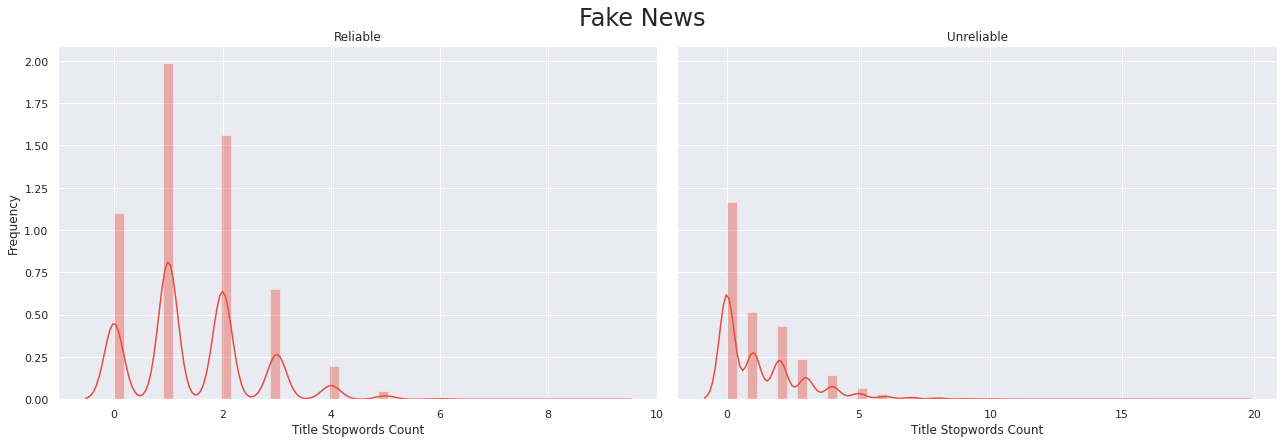

In [37]:
plot_histogram(df[df['label'] == 0]['title_stopwords'], df[df['label'] == 1]['title_stopwords'], 'Title Stopwords Count')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


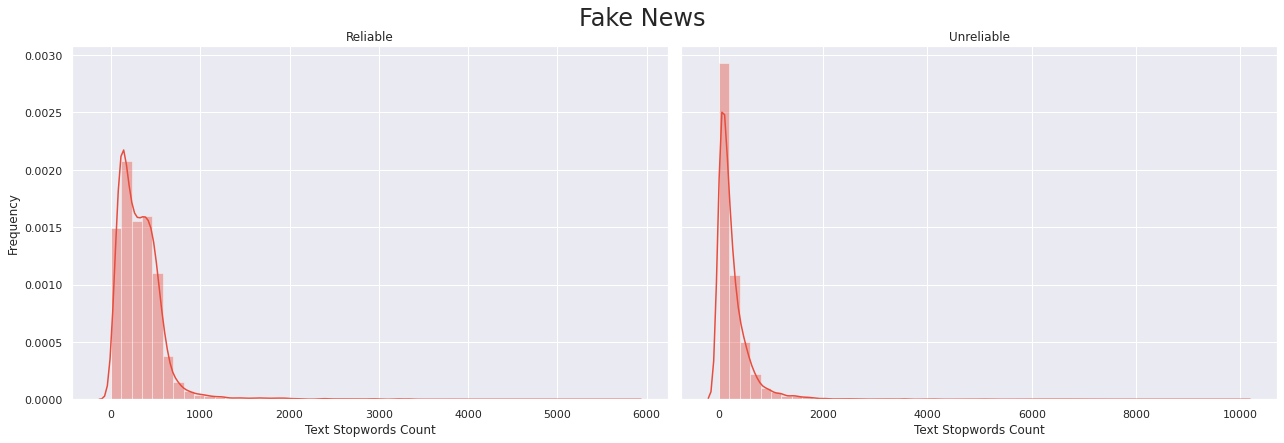

In [38]:
plot_histogram(df[df['label'] == 0]['text_stopwords'], df[df['label'] == 1]['text_stopwords'], 'Text Stopwords Count')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


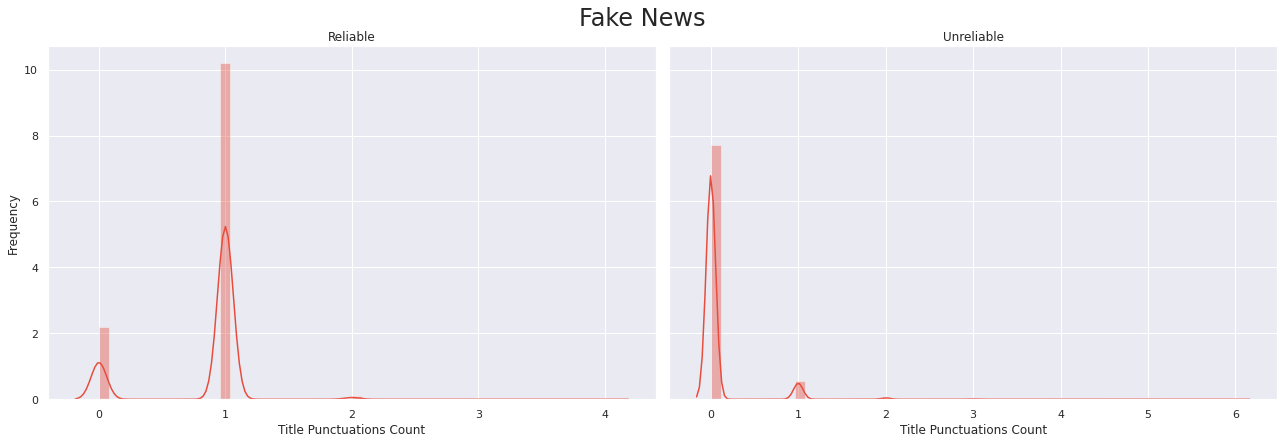

In [39]:
plot_histogram(df[df['label'] == 0]['title_puncs'], df[df['label'] == 1]['title_puncs'], 'Title Punctuations Count')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


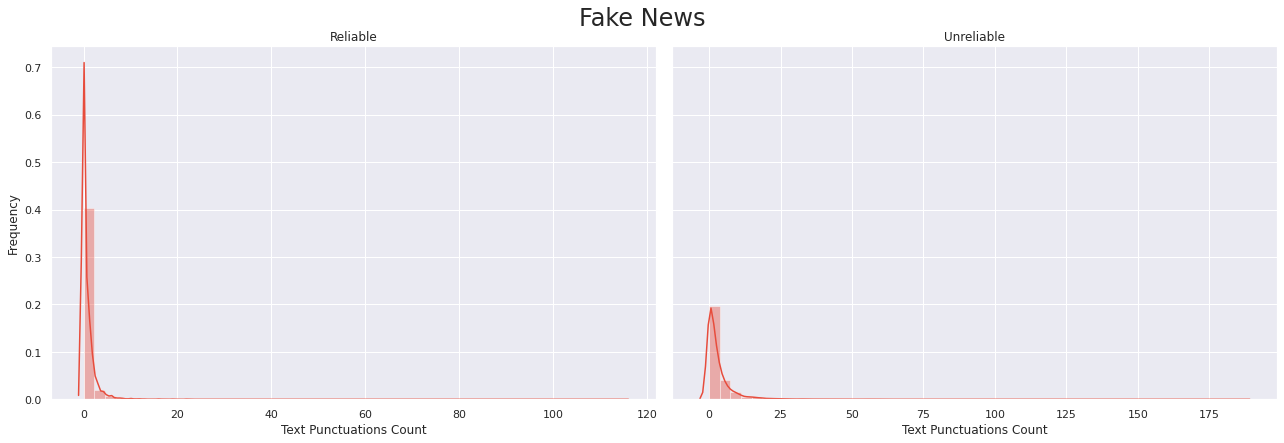

In [40]:
plot_histogram(df[df['label'] == 0]['text_puncs'], df[df['label'] == 1]['text_puncs'], 'Text Punctuations Count')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


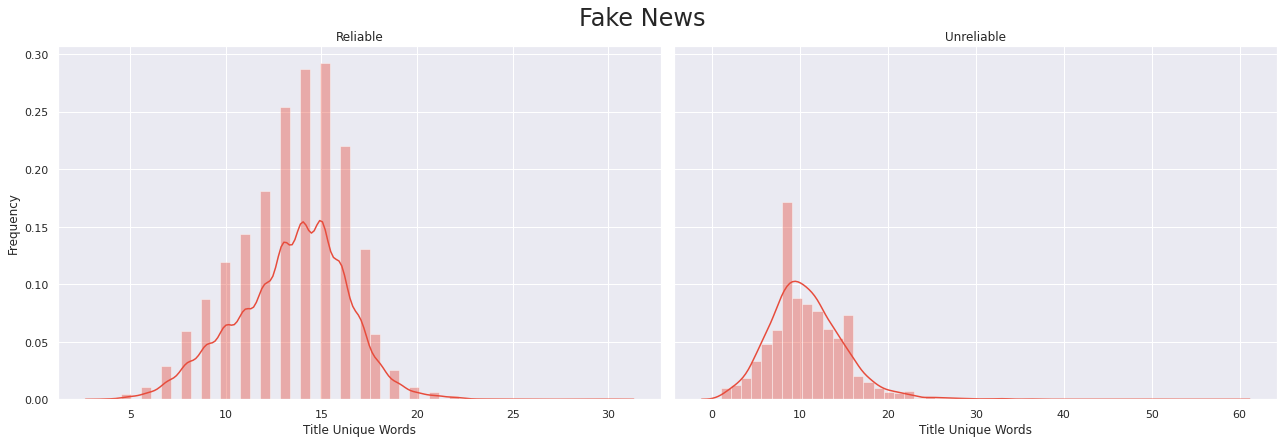

In [41]:
plot_histogram(df[df['label'] == 0]['title_unique'], df[df['label'] == 1]['title_unique'], 'Title Unique Words')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


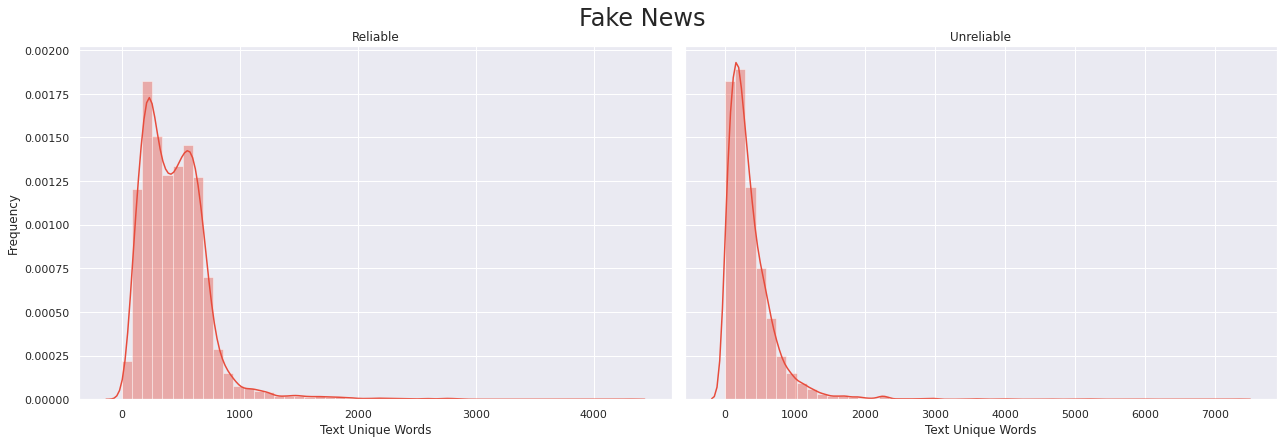

In [42]:
plot_histogram(df[df['label'] == 0]['text_unique'], df[df['label'] == 1]['text_unique'], 'Text Unique Words')

Text(0.5, 1.0, 'Data distribution of fake and real data')

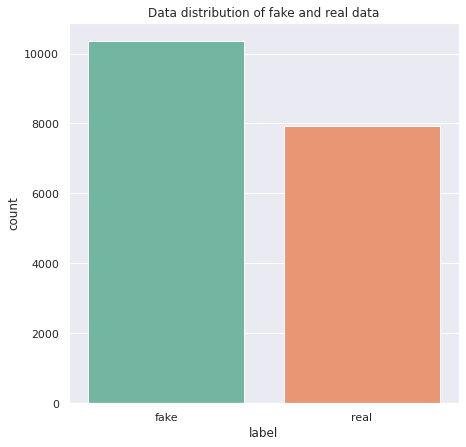

In [43]:
plt.figure(figsize=(7, 7))
sns.set(style="darkgrid")

color = sns.color_palette("Set2")
ax = sns.countplot(x="label", data=df, palette=color)

ax.set(xticklabels=['fake', 'real'])

plt.title("Data distribution of fake and real data")

In [7]:
word_embedding_model = models.Transformer('bert-base-cased')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
df = pd.read_csv('/content/train.csv')
pure_df = df.dropna()[:1000]
# len(pure_df), len(df)

In [9]:
train_examples = []

for idx, row in tqdm(pure_df.iterrows(),  total=pure_df.shape[0], desc='Converting Text into BERT Inputs ...'):
  txt = str(row['title'])
  tit = str(row['text'])
  lbl = str(row['label'])
  train_examples.append(InputExample(texts=[tit, txt, lbl]))

Converting Text into BERT Inputs ...:   0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.TripletLoss(model=model)
num_epochs = 2
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data

In [12]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/63 [00:00<?, ?it/s]

Iteration:   0%|          | 0/63 [00:00<?, ?it/s]

In [13]:
sentences = []
for idx, row in tqdm(pure_df.iterrows(),  total=pure_df.shape[0], desc='Converting Text into BERT Inputs ...'):
  txt = str(row['title'])
  tit = str(row['text'])
  lbl = str(row['label'])
  sentences.append(' '.join([tit, txt, lbl]))


Converting Text into BERT Inputs ...:   0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
sentence_embedded = model.encode(sentences)
sentence_embedded.shape
X = list(sentence_embedded)
X_embedded = TSNE(n_components=2).fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [18]:
df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label=pure_df.label.values)

In [19]:
df_embeddings

,x,y,label
0,-6.011130,-4.329370,1
1,15.244947,-9.455334,0
2,4.721198,26.400867,1
3,-10.482025,31.256630,1
4,-25.441936,-5.846022,1
...,...,...,...
995,-9.843040,6.079207,1
996,-25.534796,-10.497138,1
997,-1.502095,16.820883,0
998,-0.384698,-10.399024,1


In [20]:
import plotly.express as px

fig = px.scatter(
    df_embeddings, x='x', y='y',
    color='label', labels={'color': 'label'},
    title = 'BERT Embeddings & 2D T-SNE Visualization')
fig.show()